# Importing library

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


# Library for Keras Framework 

In [2]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os


# color image (RGB) to grayscale
# using formula  0.299*red + 0.587*green + 0.114*blue

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


# load the CIFAR10 data


In [5]:
(x_train, _), (x_test, _) = cifar10.load_data()


In [6]:
rows_img = x_train.shape[1]
cols_img = x_train.shape[2]
channels = x_train.shape[3]

In [7]:
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

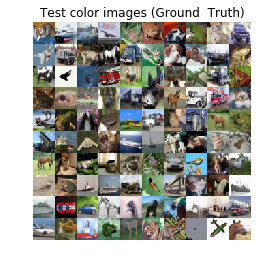

In [8]:
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, rows_img, cols_img, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [9]:

x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)


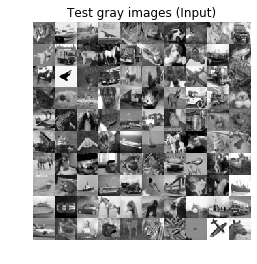

In [10]:
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, rows_img, cols_img))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

# normalize output train and test color images

In [11]:

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


# normalize input train and test grayscale images

In [12]:

x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

# reshape images to row x col x channel for CNN output/validation

In [13]:

x_train = x_train.reshape(x_train.shape[0], rows_img, cols_img, channels)
x_test = x_test.reshape(x_test.shape[0], rows_img, cols_img, channels)


# reshape images to row x col x channel for CNN input

In [14]:

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], rows_img, cols_img, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], rows_img, cols_img, 1)


# network parameters

In [ ]:

input_shape = (rows_img, cols_img, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]


# build the autoencoder model
# first build the encoder model

In [ ]:

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

Instructions for updating:
Colocations handled automatically by placer.


# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)

In [ ]:

shape = K.int_shape(x)


# generate a latent vector

In [ ]:

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

#  encoder model

In [ ]:

encoder = Model(inputs, latent, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________________________


#  decoder model

In [ ]:

latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)

In [ ]:

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)


In [ ]:
outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)


#  decoder model

In [ ]:

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731      
Total para

# autoencoder = encoder + decoder
# instantiate autoencoder model

In [ ]:

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'Nitin.model'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


In [ ]:
# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.001)

In [ ]:
 #save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


In [ ]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')


In [ ]:
# called every epoch
callbacks = [lr_reducer, checkpoint]


In [ ]:
# train the autoencoder
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=10,
                batch_size=batch_size,
                callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 917s 18ms/step - loss: 0.0154 - val_loss: 0.0110

Epoch 00001: val_loss improved from inf to 0.01103, saving model to /home/v-nitin.gupta/Desktop/ipython notebook/pytorch /saved_models/Nitin.model
Epoch 2/10
50000/50000 [==============================] - 541s 11ms/step - loss: 0.0101 - val_loss: 0.0095

Epoch 00002: val_loss improved from 0.01103 to 0.00947, saving model to /home/v-nitin.gupta/Desktop/ipython notebook/pytorch /saved_models/Nitin.model
Epoch 3/10
50000/50000 [==============================] - 484s 10ms/step - loss: 0.0091 - val_loss: 0.0090

Epoch 00003: val_loss improved from 0.00947 to 0.00900, saving model to /home/v-nitin.gupta/Desktop/ipython notebook/pytorch /saved_models/Nitin.model
Epoch 4/10
50000/50000 [==============================] - 485s 10ms/step - loss: 0.0086 - val_loss: 0.0084

Epoch 00004: val_loss

In [ ]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, rows_img, cols_img, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()